In [1]:
# generate toy data
import numpy as np
import time

rng = np.random.RandomState(1)

data_x = rng.uniform(low=-4, high=4, size=(20,))
data_y = data_x**3 + rng.normal(loc=0, scale=9, size=(20,))

linspace = np.linspace(-6, 6, num=500)

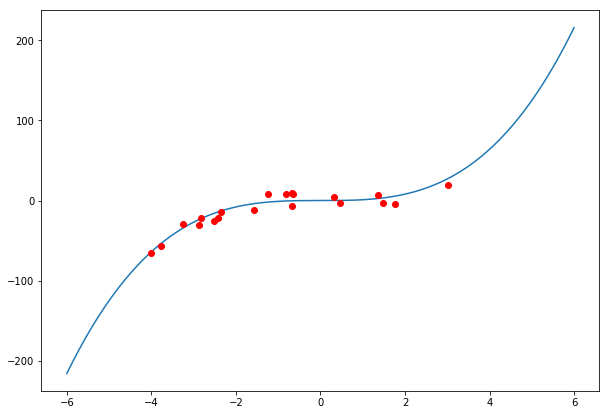

In [2]:
# plot toy data
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
plt.plot(linspace, linspace ** 3)
plt.plot(data_x, data_y, 'ro')
plt.show()

In [3]:
# import some stuff
from __future__ import division, print_function

import os

# set gpu device - only important for multi gpu systems
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf

from tqdm import tqdm
import pandas as pd
import layers 

/homes/np716/.virtualenvs/python2.7/local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
hidden = 100
h_units = [16, 32, 64]
# function to build network dependent on mode
def get_net(mode, ops):
    with tf.variable_scope('net'):
        x = tf.placeholder(tf.float32, [None, 1])
        y = tf.placeholder(tf.float32, [None, 1])
        
        # build distribution with fixed scale for loss 
        n = tf.distributions.Normal(loc=0., scale=9.)
        
        ops['x'] = x
        ops['y'] = y
        
        if mode == 'ensemble':
            adv_alpha = 0.5
            adv_eps = 1e-2
            ops['pred'] = []
            ops['loss'] = []
            ops['adv_loss'] = []
            ops['tot_loss'] = []
            for i in range(10):
                with tf.variable_scope('ens{}'.format(i)):
                    l1 = tf.layers.Dense(units=hidden, activation=tf.nn.relu)
                    l2 = tf.layers.Dense(units=1)
                    
                    x_ = l2(l1(x))

                    # build loss
                    loss = tf.reduce_mean(-1 * n.log_prob(x_ - y))
                    
                    loss_grads = tf.gradients(adv_alpha * loss, x)[0]
                    adv_data = x + adv_eps * tf.sign(loss_grads)

                    adv_pred = l2(l1(adv_data))
                    adv_loss = tf.reduce_mean(-1 * n.log_prob(adv_pred - y))

                    tot_loss = adv_alpha * loss + (1 - adv_alpha) * adv_loss

                ops['pred'].append(x_)
                ops['loss'].append(loss)
                ops['adv_loss'].append(adv_loss)
                ops['tot_loss'].append(tot_loss)
        else:
            if mode == 'implicit':
                l1 = layers.BBHDenseLayer('l1', 1, hidden, h_units=h_units, h_use_bias=True)

                x = l1(x)
                x = tf.nn.relu(x)

                # layer 2
                l2 = layers.BBHDenseLayer('l2', hidden, 1, h_units=h_units, h_use_bias=True)

                x = l2(x)

                # build loss
                loss = tf.reduce_mean(-1 * n.log_prob(x - y))
            elif mode == 'bbb':

                # layer 1
                l1 = layers.BBBDenseLayer('l1', 1, hidden, init_var=-3.)

                x = l1(x)
                x = tf.nn.relu(x)

                # layer 2
                l2 = layers.BBBDenseLayer('l2', hidden, 1, init_var=-3.)

                x = l2(x)


                kl_loss = tf.add_n(tf.get_collection('bbb_kl'))

                # build loss
                loss = tf.reduce_mean(-1 * n.log_prob(x - y))

                ops['kl_loss'] = kl_loss

            elif mode == 'mnf':
                learn_p = False

                # layer 1
                l1 = layers.MNFDenseLayer('l1', 1, hidden, thres_var=0.5, learn_p=learn_p)

                x = l1(x)
                x = tf.nn.relu(x)

                # layer 2
                l2 = layers.MNFDenseLayer('l2', hidden, 1, thres_var=0.5, learn_p=learn_p)

                x = l2(x)

                # build loss
                loss = tf.reduce_mean(-1 * n.log_prob(x - y))

                kl_loss = tf.add_n(tf.get_collection('mnf_kl'))# / 20.


                ops['kl_loss'] = kl_loss

            elif mode == 'dropout':
                x = tf.layers.dense(inputs=x, units=hidden, activation=tf.nn.relu)
                x = tf.nn.dropout(x, 0.5)

                x = tf.layers.dense(inputs=x, units=1)
                # build loss
                loss = tf.reduce_mean(-1 * n.log_prob(x - y))
            else:
                x = tf.layers.dense(inputs=x, units=hidden, activation=tf.nn.relu)

                x = tf.layers.dense(inputs=x, units=1)
                # build loss
                loss = tf.reduce_mean(-1 * n.log_prob(x - y))

            ops['pred'] = x
            ops['loss'] = loss
        
        return ops

In [5]:
# dataframe to hold results
tf.set_random_seed(1)
cols = ['x', 'y', 'mode', 'mc']
prediction_df = pd.DataFrame(columns=cols)
for mode in ['bbb', 'mnf', 'ensemble', 'dropout', 'implicit', 'vanilla']:
    print(mode)

    tf.reset_default_graph()
    
    ops = {}

    # get network ops
    ops = get_net(mode, ops)

    net_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'net')

    lr = 0.02 if mode == 'implicit' else 0.1
    opt = tf.train.AdamOptimizer(lr, epsilon=1e-5)
    
    anneal = tf.placeholder_with_default(1., [])

    if mode == 'implicit': # build custom training ops for implicit
        num_samples = 5
        gen_weights = tf.concat(tf.get_collection('gen_weights'), 1)
        gen_weights = tf.reshape(gen_weights, (-1, 1))
        
        prior = tf.distributions.Normal(loc=0., scale=1.)
        prior_samples = prior.sample(tf.shape(gen_weights))
        
        wp_dist = tf.reduce_min(tf.sqrt(tf.square(
            tf.expand_dims(prior_samples, 2)
            - tf.expand_dims(gen_weights, 1)) + 1e-8), 1)

        ww_dist = tf.reduce_min(tf.sqrt(tf.square(
            tf.expand_dims(gen_weights, 2)
            - tf.expand_dims(gen_weights, 1)) + 1e-8)
                                + tf.expand_dims(tf.eye(num_samples) * 1e10, 0), 1)

        kl = tf.reduce_sum(tf.reduce_mean(
            tf.log(wp_dist / (ww_dist + 1e-8) + 1e-8)
            + tf.log(float(num_samples) / (num_samples - 1)), 1))
        
        

        loss_g = ops['loss'] + anneal * kl
        
        ops['kl_loss'] = kl

        gvs = opt.compute_gradients(loss_g)
        optimiser = opt.apply_gradients(gvs)
    elif mode == 'bbb' or mode == 'mnf':
        optimiser = opt.minimize(ops['loss'] + anneal * ops['kl_loss'])
    elif mode == 'ensemble':
        optimiser = [opt.minimize(tot_loss) for tot_loss in ops['tot_loss']]
    else:
        optimiser = opt.minimize(ops['loss'])

    # build function to hold predictions
    # pred = ops['pred']

    # build op to initialise the variables
    init = tf.global_variables_initializer()

    numerics = tf.add_check_numerics_ops()
    
    s = tf.Session()

    # initialise the weights
    s.run(init)
    

    from tqdm import trange
    with trange(40) as pbar: # run for 40 epochs
        for i in pbar: #300 epochs
            # get batch from dataset
            if mode =='implicit' or mode == 'bbb' or mode == 'mnf':
                cur_anneal = np.clip(10. / (i + 1) - 2., 0., 1.)
                l_loss, kl_loss, _ = s.run([ops['loss'], ops['kl_loss'], optimiser],
                                          feed_dict={ops['x']: data_x[:, np.newaxis],
                                                     ops['y']: data_y[:, np.newaxis],
                                                     anneal: cur_anneal
                                                    })
                pbar.set_postfix(ce=l_loss, kl_loss=kl_loss)
            elif mode == 'ensemble':
                ce = 0
                for loss, opt in zip(ops['loss'], optimiser):
                    l_loss, _ = s.run([loss, opt],
                                      feed_dict={ops['x']: data_x[:, np.newaxis],
                                                 ops['y']: data_y[:, np.newaxis]})
                    ce += l_loss / 10
                pbar.set_postfix(ce=ce)
            else:
                l_loss, _ = s.run([ops['loss'], optimiser],
                                          feed_dict={ops['x']: data_x[:, np.newaxis], ops['y']: data_y[:, np.newaxis]})

                pbar.set_postfix(ce=l_loss)
        pbar.close()
    
    # run predictions after training
    all_preds = np.zeros(len(linspace))
    if mode == 'dropout' or mode == 'implicit' or mode == 'bbb' or mode == 'mnf':
        mcsteps = 100
        
        for mc in range(mcsteps):
            predictions = s.run(ops['pred'], {ops['x']: linspace[:, np.newaxis]})[:, 0]
            all_preds += predictions / mcsteps
            new_df = pd.DataFrame(columns=cols, data=zip(linspace, predictions,
                                                     [mode]*len(linspace), [mc]*len(linspace)))
            
            prediction_df = pd.concat([prediction_df, new_df])
    elif mode == 'ensemble':
        for i, pred in enumerate(ops['pred']):
            predictions = s.run(pred, {ops['x']: linspace[:, np.newaxis]})[:, 0]
            all_preds += predictions / 10
            new_df = pd.DataFrame(columns=cols, data=zip(linspace, predictions,
                                                     [mode]*len(linspace), [i]*len(linspace)))
            
            prediction_df = pd.concat([prediction_df, new_df])
    else:
        predictions = s.run(ops['pred'], {ops['x']: linspace[:, np.newaxis]})[:, 0]
        all_preds += predictions
        new_df = pd.DataFrame(columns=cols, data=zip(linspace, predictions,
                                                     [mode]*len(linspace), [0]*len(linspace)))
        
        prediction_df = pd.concat([prediction_df, new_df])
    
    print(np.sqrt(np.mean((all_preds - linspace ** 3)**2)))
    
    if mode == 'implicit':
        weight_dict = {0: [], 1:[], 2:[], 3:[]}
        for _ in range(1000):
            weight_list = s.run(tf.get_collection('gen_weights'))
            for i, w in  enumerate(weight_list):
                weight_dict[i].append(w[0])
        
    
    

bbb


100%|██████████| 40/40 [00:00<00:00, 60.33it/s, ce=3.59, kl_loss=205]


61.05802582662386
mnf


100%|██████████| 40/40 [00:01<00:00, 26.32it/s, ce=5.56, kl_loss=1.13e+04]


67.4660606582583
ensemble


100%|██████████| 40/40 [00:02<00:00, 16.82it/s, ce=3.34]


30.48570933438722
dropout


100%|██████████| 40/40 [00:00<00:00, 241.45it/s, ce=3.77]


57.602546762232855
implicit


100%|██████████| 40/40 [00:00<00:00, 62.31it/s, ce=3.84, kl_loss=1.43e+04]


57.84715040842469
vanilla


100%|██████████| 40/40 [00:00<00:00, 231.36it/s, ce=3.37]

40.22249755910777


In [6]:
t = {'mnf': 'MNF', 'bbb': 'Bayes by Backprop', 'implicit': 'Bayes by Hypernet',
     'dropout': 'MC-Dropout', 'vanilla': 'MAP', 'ensemble': 'Ensemble'}

prediction_df['title'] = [t[f] for f in prediction_df['mode']]

/homes/np716/.virtualenvs/python2.7/local/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


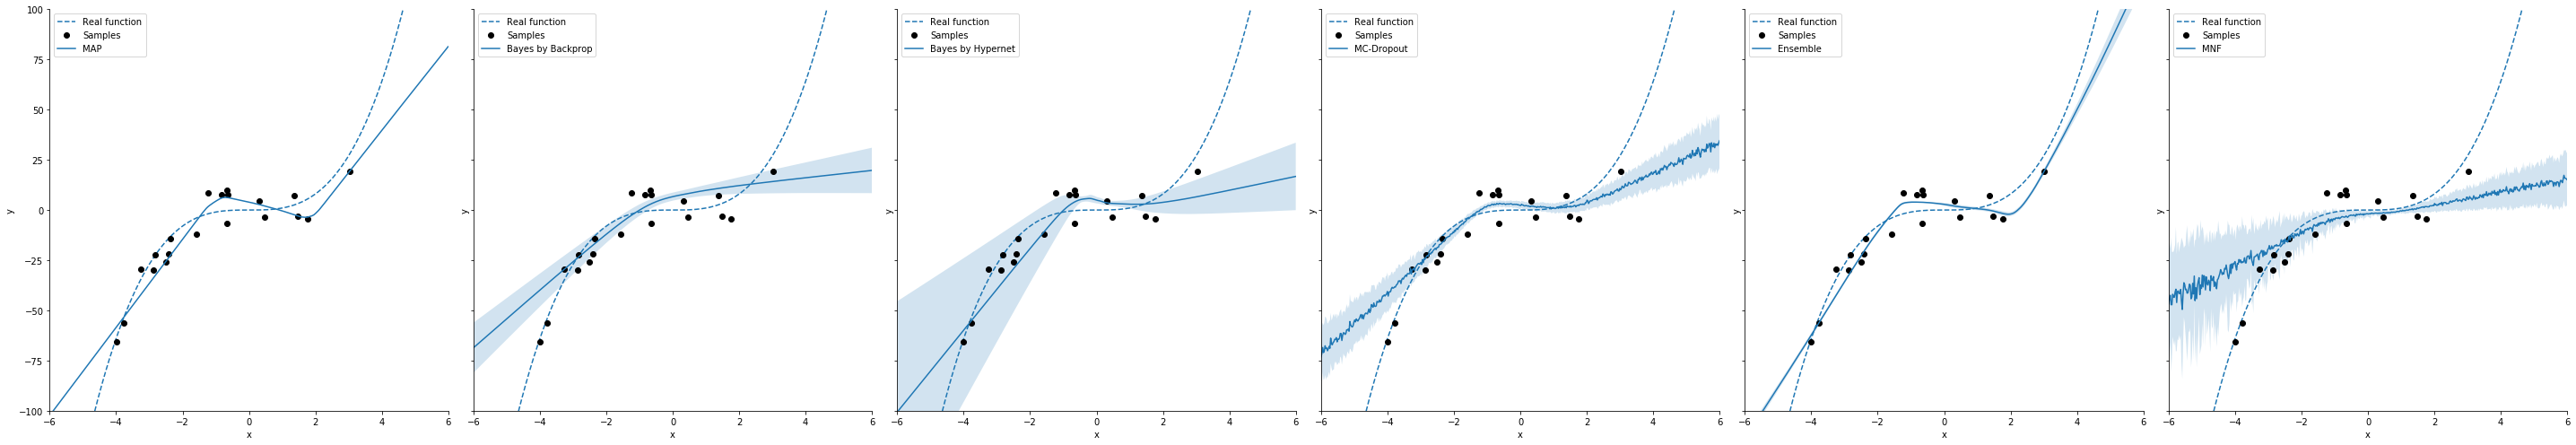

In [7]:
fig, axes = plt.subplots(1, 6, figsize=(40, 7), sharey=True)
for i, (mode, label) in enumerate(t.items()):
    mode_df = prediction_df[prediction_df['mode'] == mode]
    #axes[i].set_title(label)
    axes[i].plot(linspace, linspace ** 3, '--', label='Real function')
    axes[i].plot(data_x, data_y, 'o', color='black', label='Samples')
    sns.tsplot(mode_df, time='x', value='y', condition='title', unit='mc', ci='sd', ax=axes[i])
    l = axes[i].legend(loc=0)
    l.set_title('')
plt.ylim(-100, 100)
sns.despine()
plt.tight_layout()
plt.show()

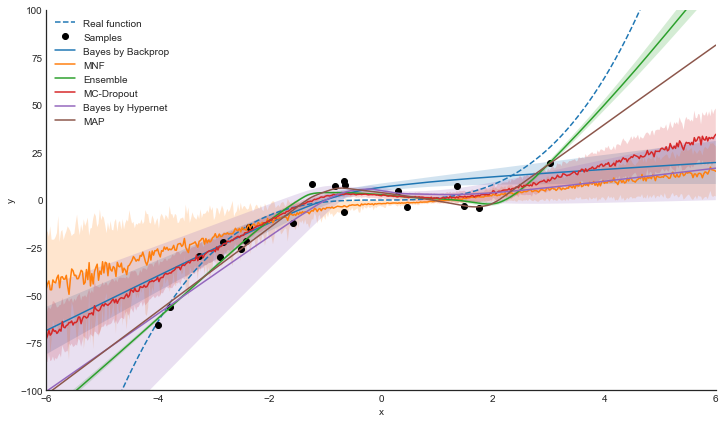

In [8]:
# plot results
t = {'mnf': 'MNF', 'bbb': 'Bayes by Backprop', 'implicit': 'Bayes by Hypernet',
     'dropout': 'MC-Dropout', 'vanilla': 'MAP', 'ensemble': 'Ensemble'}

prediction_df['title'] = [t[f] for f in prediction_df['mode']]
sns.set_style('white')

plt.figure(figsize=(12, 7))
plt.plot(linspace, linspace ** 3, '--', label='Real function')
plt.plot(data_x, data_y, 'o', color='black', label='Samples')
sns.tsplot(prediction_df, time='x', value='y', condition='title', unit='mc', ci='sd')
           #ci=[68.27, 95.45, 99.73, 99.9999], n_boot=1000)#, err_style="boot_traces")
plt.ylim(-100, 100)
l = plt.legend(loc=0)
l.set_title('')
sns.despine()
plt.show()

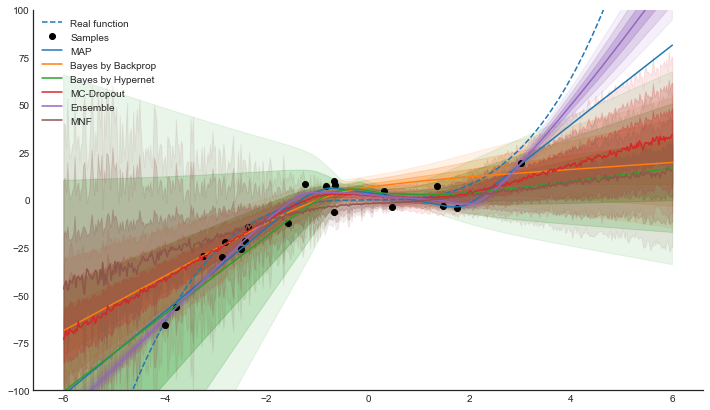

In [9]:
colours = sns.color_palette(n_colors=6)

plt.figure(figsize=(12, 7))
plt.plot(linspace, linspace ** 3, '--', label='Real function')
plt.plot(data_x, data_y, 'o', color='black', label='Samples')
for i, (mode, label) in enumerate(t.items()):
    mode_df = prediction_df[prediction_df['mode'] == mode]
    groups = mode_df.groupby(['x'])
    mean_pred = groups.mean().as_matrix()[:, 0]
    std_pred = groups.std().as_matrix()[:, 0]
    plt.plot(linspace, mean_pred, color=colours[i], label=label)
    
    if not mode == 'vanilla':
        plt.fill_between(linspace,
                         mean_pred + 1 * std_pred,
                         mean_pred - 1 * std_pred,
                         color=colours[i], alpha=0.3)
        plt.fill_between(linspace,
                         mean_pred + 2 * std_pred,
                         mean_pred - 2 * std_pred,
                         color=colours[i], alpha=0.2)
        plt.fill_between(linspace,
                         mean_pred + 3 * std_pred,
                         mean_pred - 3 * std_pred,
                         color=colours[i], alpha=0.1)
plt.ylim(-100, 100)
l = plt.legend(loc=0)
l.set_title('')
sns.despine()
plt.show()

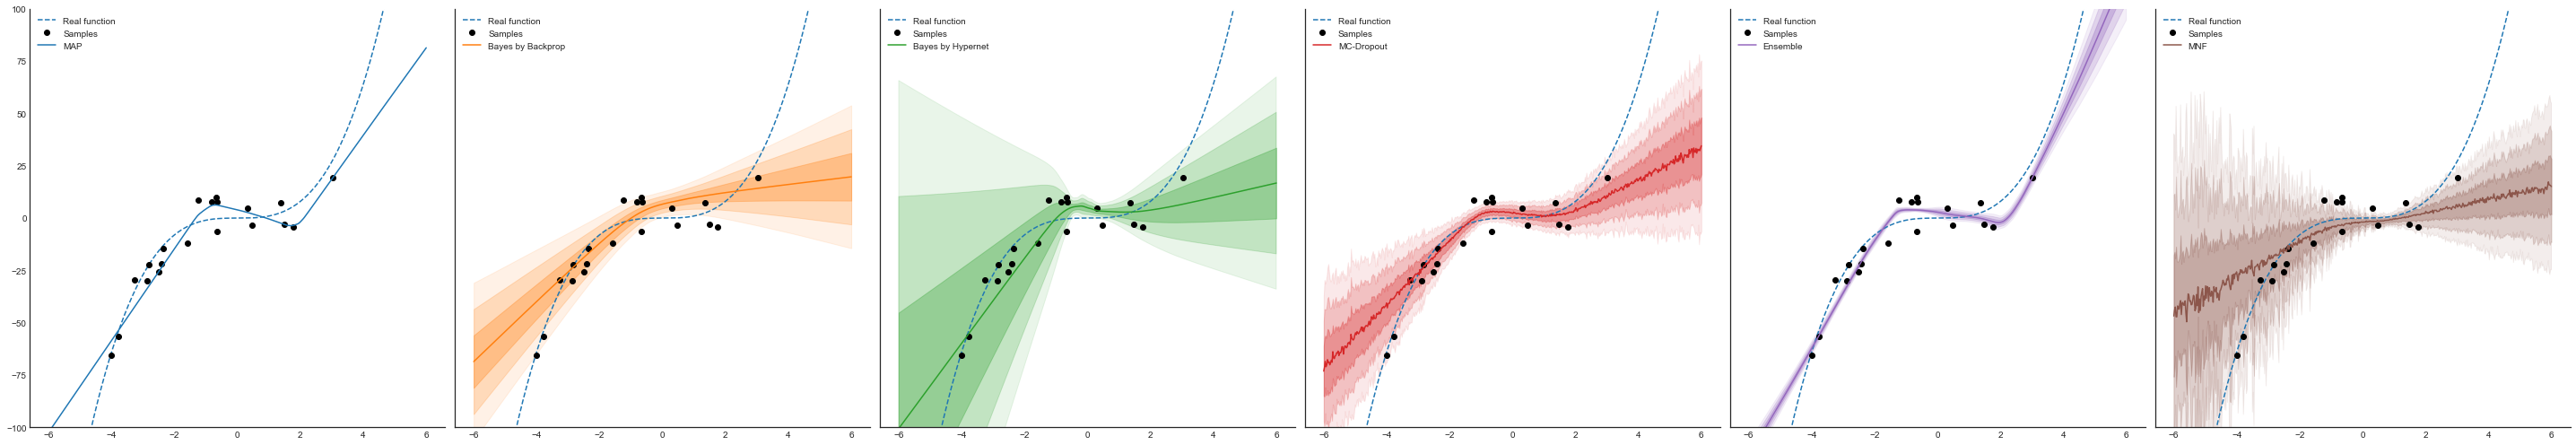

In [10]:
fig, axes = plt.subplots(1, 6, figsize=(40, 7), sharey=True)
for i, (mode, label) in enumerate(t.items()):
    #axes[i].set_title(label)
    axes[i].plot(linspace, linspace ** 3, '--', label='Real function')
    axes[i].plot(data_x, data_y, 'o', color='black', label='Samples')
    
    mode_df = prediction_df[prediction_df['mode'] == mode]
    groups = mode_df.groupby(['x'])
    mean_pred = groups.mean().as_matrix()[:, 0]
    std_pred = groups.std().as_matrix()[:, 0]
    axes[i].plot(linspace, mean_pred, color=colours[i], label=label)
    
    if not mode == 'vanilla':
        axes[i].fill_between(linspace,
                         mean_pred + 1 * std_pred,
                         mean_pred - 1 * std_pred,
                         color=colours[i], alpha=0.3)
        axes[i].fill_between(linspace,
                         mean_pred + 2 * std_pred,
                         mean_pred - 2 * std_pred,
                         color=colours[i], alpha=0.2)
        axes[i].fill_between(linspace,
                         mean_pred + 3 * std_pred,
                         mean_pred - 3 * std_pred,
                         color=colours[i], alpha=0.1)
        
    l = axes[i].legend(loc=0)
    l.set_title('')
plt.ylim(-100, 100)
sns.despine()
plt.tight_layout()
plt.show()

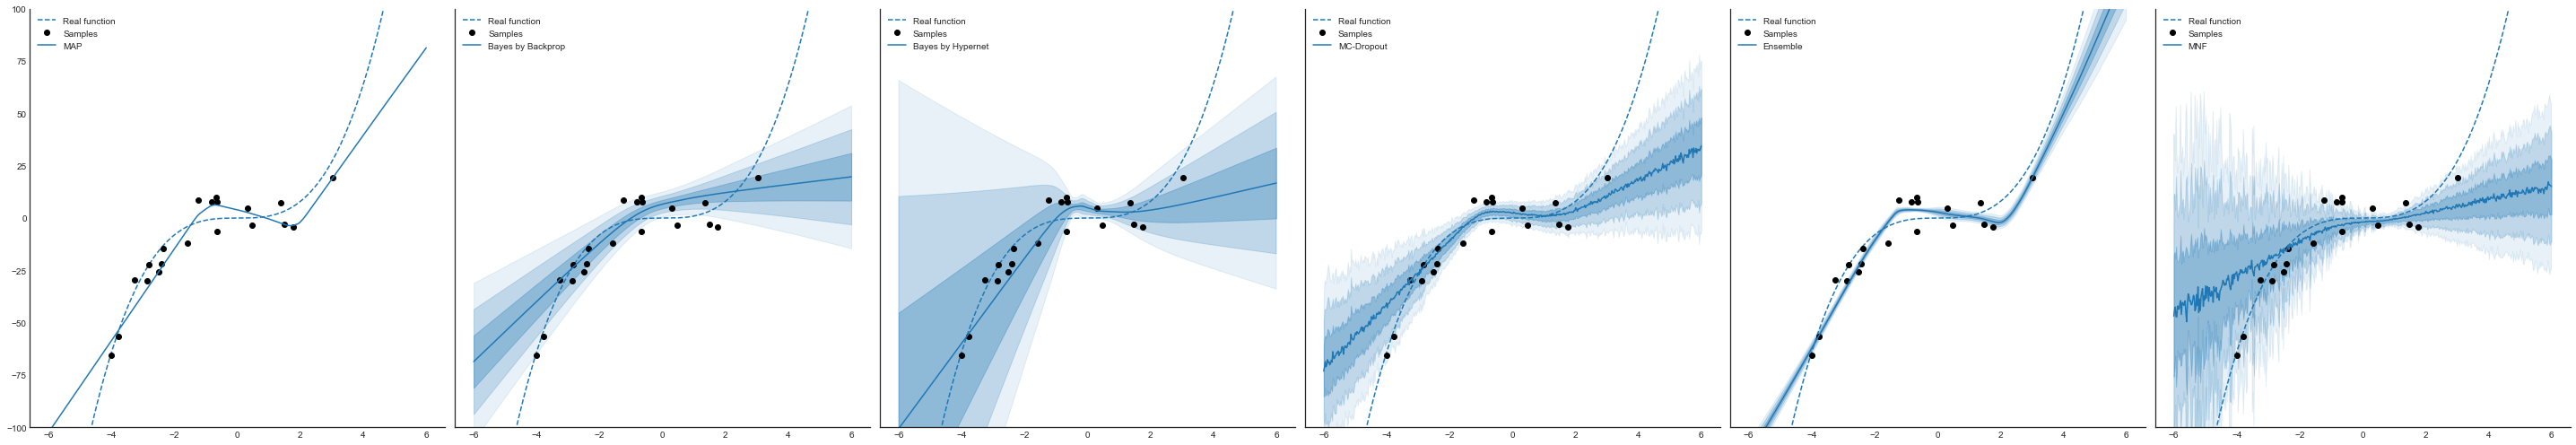

In [11]:
fig, axes = plt.subplots(1, 6, figsize=(40, 7), sharey=True)
for i, (mode, label) in enumerate(t.items()):
    #axes[i].set_title(label)
    axes[i].plot(linspace, linspace ** 3, '--', label='Real function')
    axes[i].plot(data_x, data_y, 'o', color='black', label='Samples')
    
    mode_df = prediction_df[prediction_df['mode'] == mode]
    groups = mode_df.groupby(['x'])
    mean_pred = groups.mean().as_matrix()[:, 0]
    std_pred = groups.std().as_matrix()[:, 0]
    axes[i].plot(linspace, mean_pred, color=colours[0], label=label)
    
    if not mode == 'vanilla':
        axes[i].fill_between(linspace,
                         mean_pred + 1 * std_pred,
                         mean_pred - 1 * std_pred,
                         color=colours[0], alpha=0.3)
        axes[i].fill_between(linspace,
                         mean_pred + 2 * std_pred,
                         mean_pred - 2 * std_pred,
                         color=colours[0], alpha=0.2)
        axes[i].fill_between(linspace,
                         mean_pred + 3 * std_pred,
                         mean_pred - 3 * std_pred,
                         color=colours[0], alpha=0.1)
        
    l = axes[i].legend(loc=0)
    l.set_title('')
plt.ylim(-100, 100)
sns.despine()
plt.tight_layout()
plt.show()

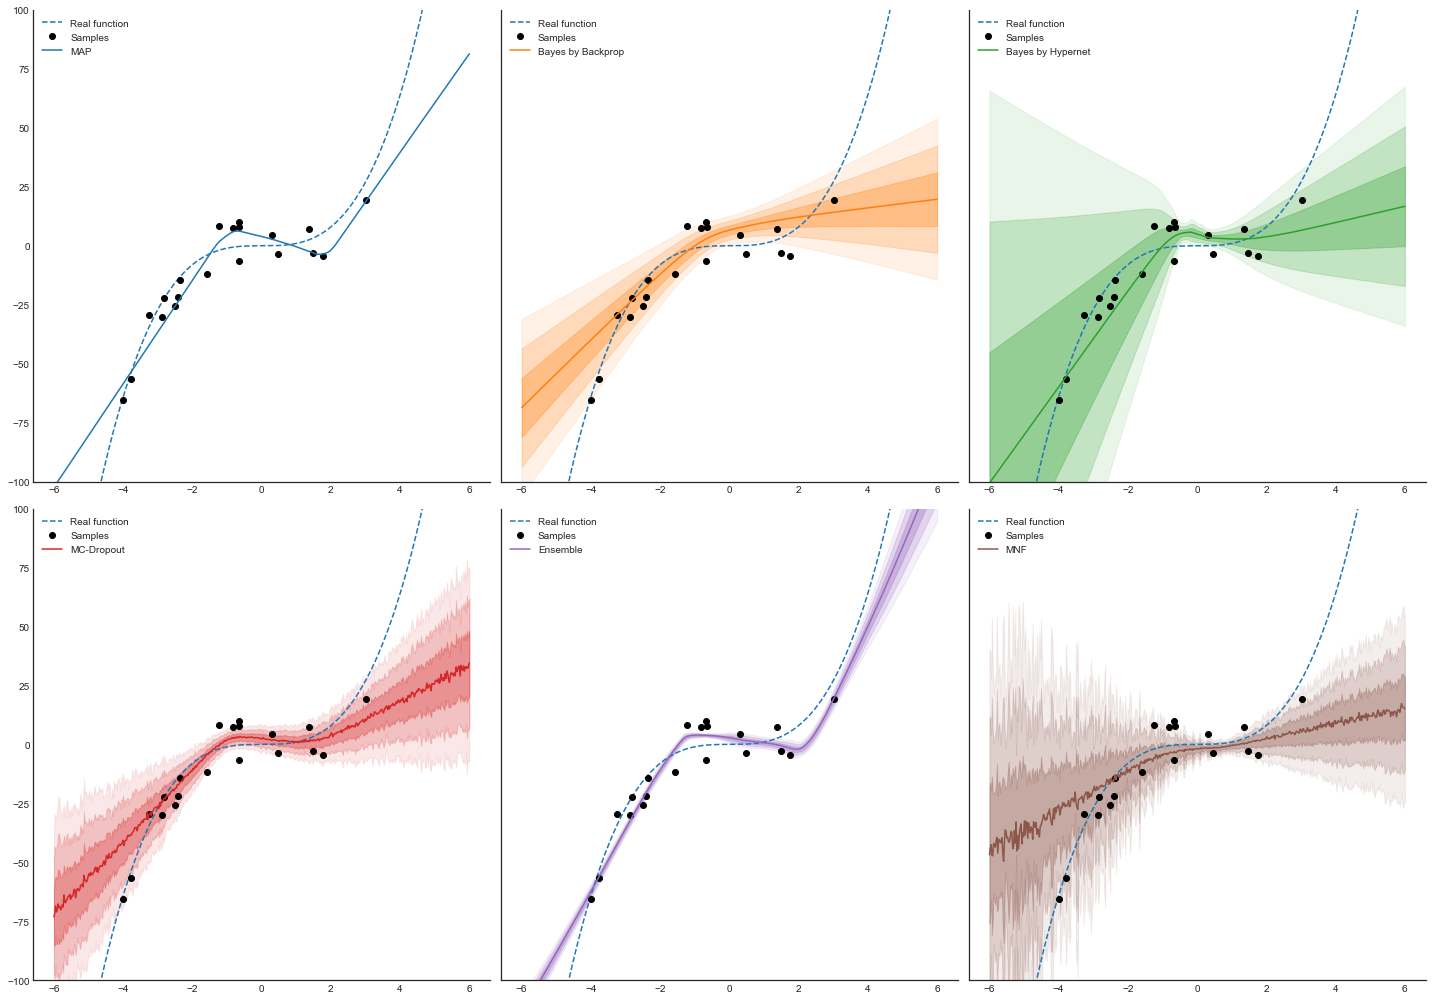

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(20, 14), sharey=True)
for i, (mode, label) in enumerate(t.items()):
    row = i // 3
    col = i % 3
    #axes[row, col].set_title(label)
    axes[row, col].plot(linspace, linspace ** 3, '--', label='Real function')
    axes[row, col].plot(data_x, data_y, 'o', color='black', label='Samples')
    
    mode_df = prediction_df[prediction_df['mode'] == mode]
    groups = mode_df.groupby(['x'])
    mean_pred = groups.mean().as_matrix()[:, 0]
    std_pred = groups.std().as_matrix()[:, 0]
    axes[row, col].plot(linspace, mean_pred, color=colours[i], label=label)
    
    if not mode == 'vanilla':
        axes[row, col].fill_between(linspace,
                         mean_pred + 1 * std_pred,
                         mean_pred - 1 * std_pred,
                         color=colours[i], alpha=0.3)
        axes[row, col].fill_between(linspace,
                         mean_pred + 2 * std_pred,
                         mean_pred - 2 * std_pred,
                         color=colours[i], alpha=0.2)
        axes[row, col].fill_between(linspace,
                         mean_pred + 3 * std_pred,
                         mean_pred - 3 * std_pred,
                         color=colours[i], alpha=0.1)
        
    l = axes[row, col].legend(loc=0)
    l.set_title('')
plt.ylim(-100, 100)
sns.despine()
plt.tight_layout()
plt.show()

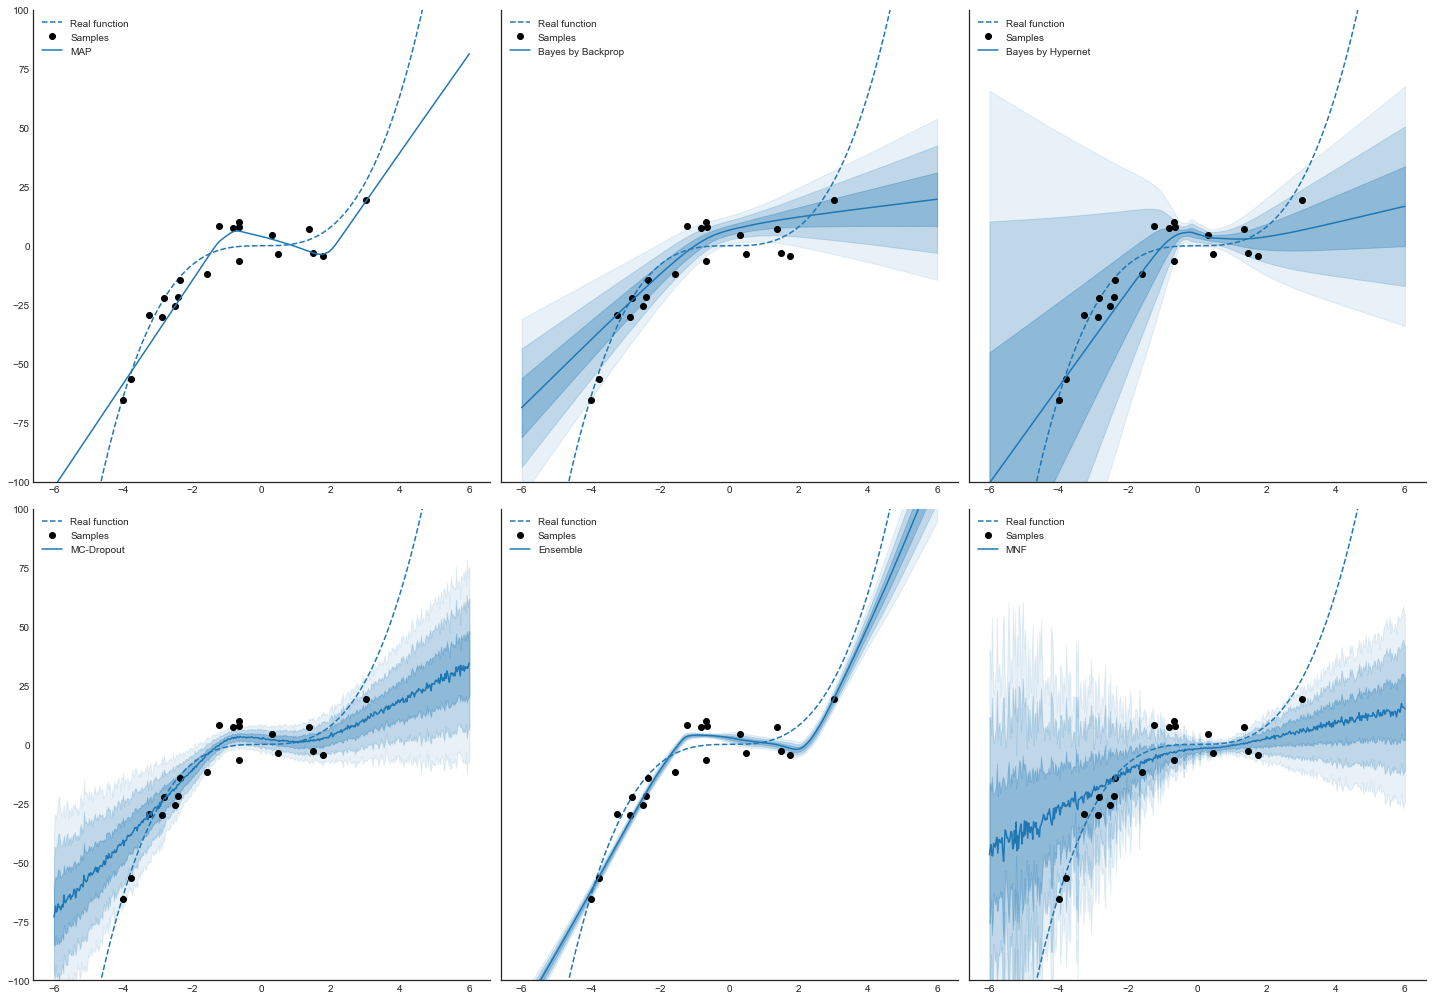

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(20, 14), sharey=True)
for i, (mode, label) in enumerate(t.items()):
    row = i // 3
    col = i % 3
    #axes[row, col].set_title(label)
    axes[row, col].plot(linspace, linspace ** 3, '--', label='Real function')
    axes[row, col].plot(data_x, data_y, 'o', color='black', label='Samples')
    
    mode_df = prediction_df[prediction_df['mode'] == mode]
    groups = mode_df.groupby(['x'])
    mean_pred = groups.mean().as_matrix()[:, 0]
    std_pred = groups.std().as_matrix()[:, 0]
    axes[row, col].plot(linspace, mean_pred, color=colours[0], label=label)
    
    if not mode == 'vanilla':
        axes[row, col].fill_between(linspace,
                         mean_pred + 1 * std_pred,
                         mean_pred - 1 * std_pred,
                         color=colours[0], alpha=0.3)
        axes[row, col].fill_between(linspace,
                         mean_pred + 2 * std_pred,
                         mean_pred - 2 * std_pred,
                         color=colours[0], alpha=0.2)
        axes[row, col].fill_between(linspace,
                         mean_pred + 3 * std_pred,
                         mean_pred - 3 * std_pred,
                         color=colours[0], alpha=0.1)
        
    l = axes[row, col].legend(loc=0)
    l.set_title('')
plt.ylim(-100, 100)
sns.despine()
plt.tight_layout()
plt.show()

w1


/homes/np716/.virtualenvs/python2.7/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


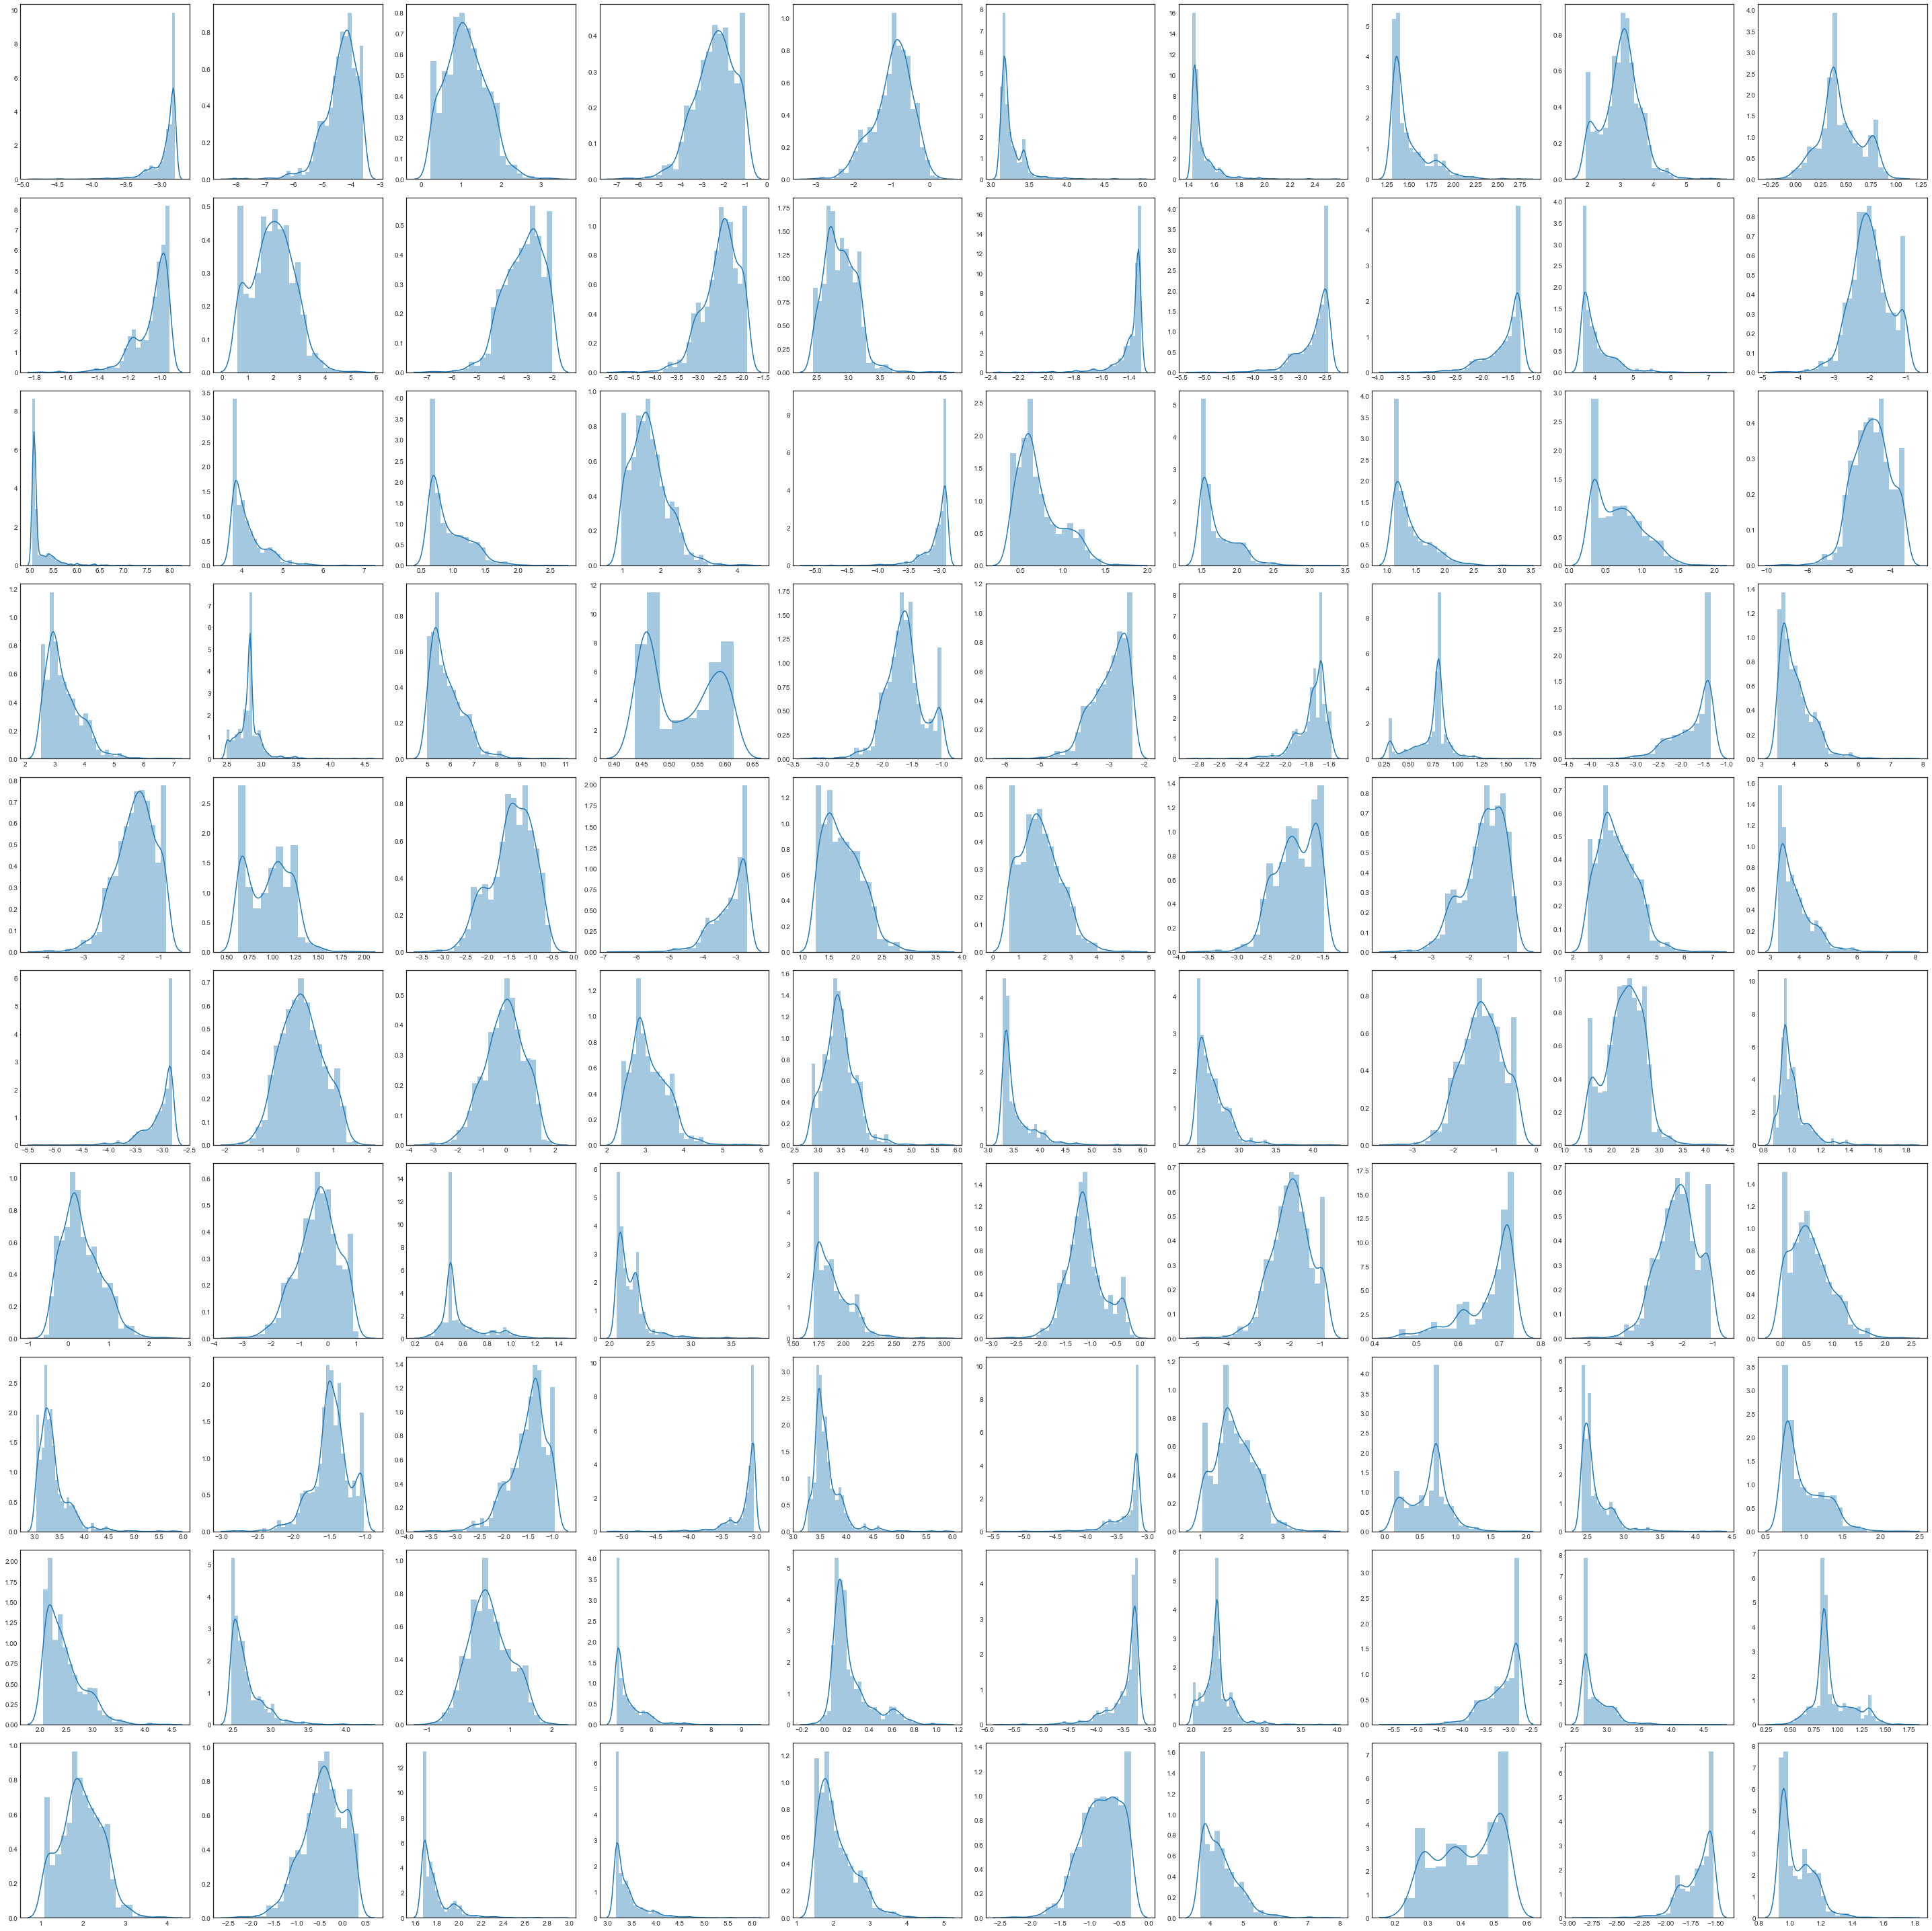

b1


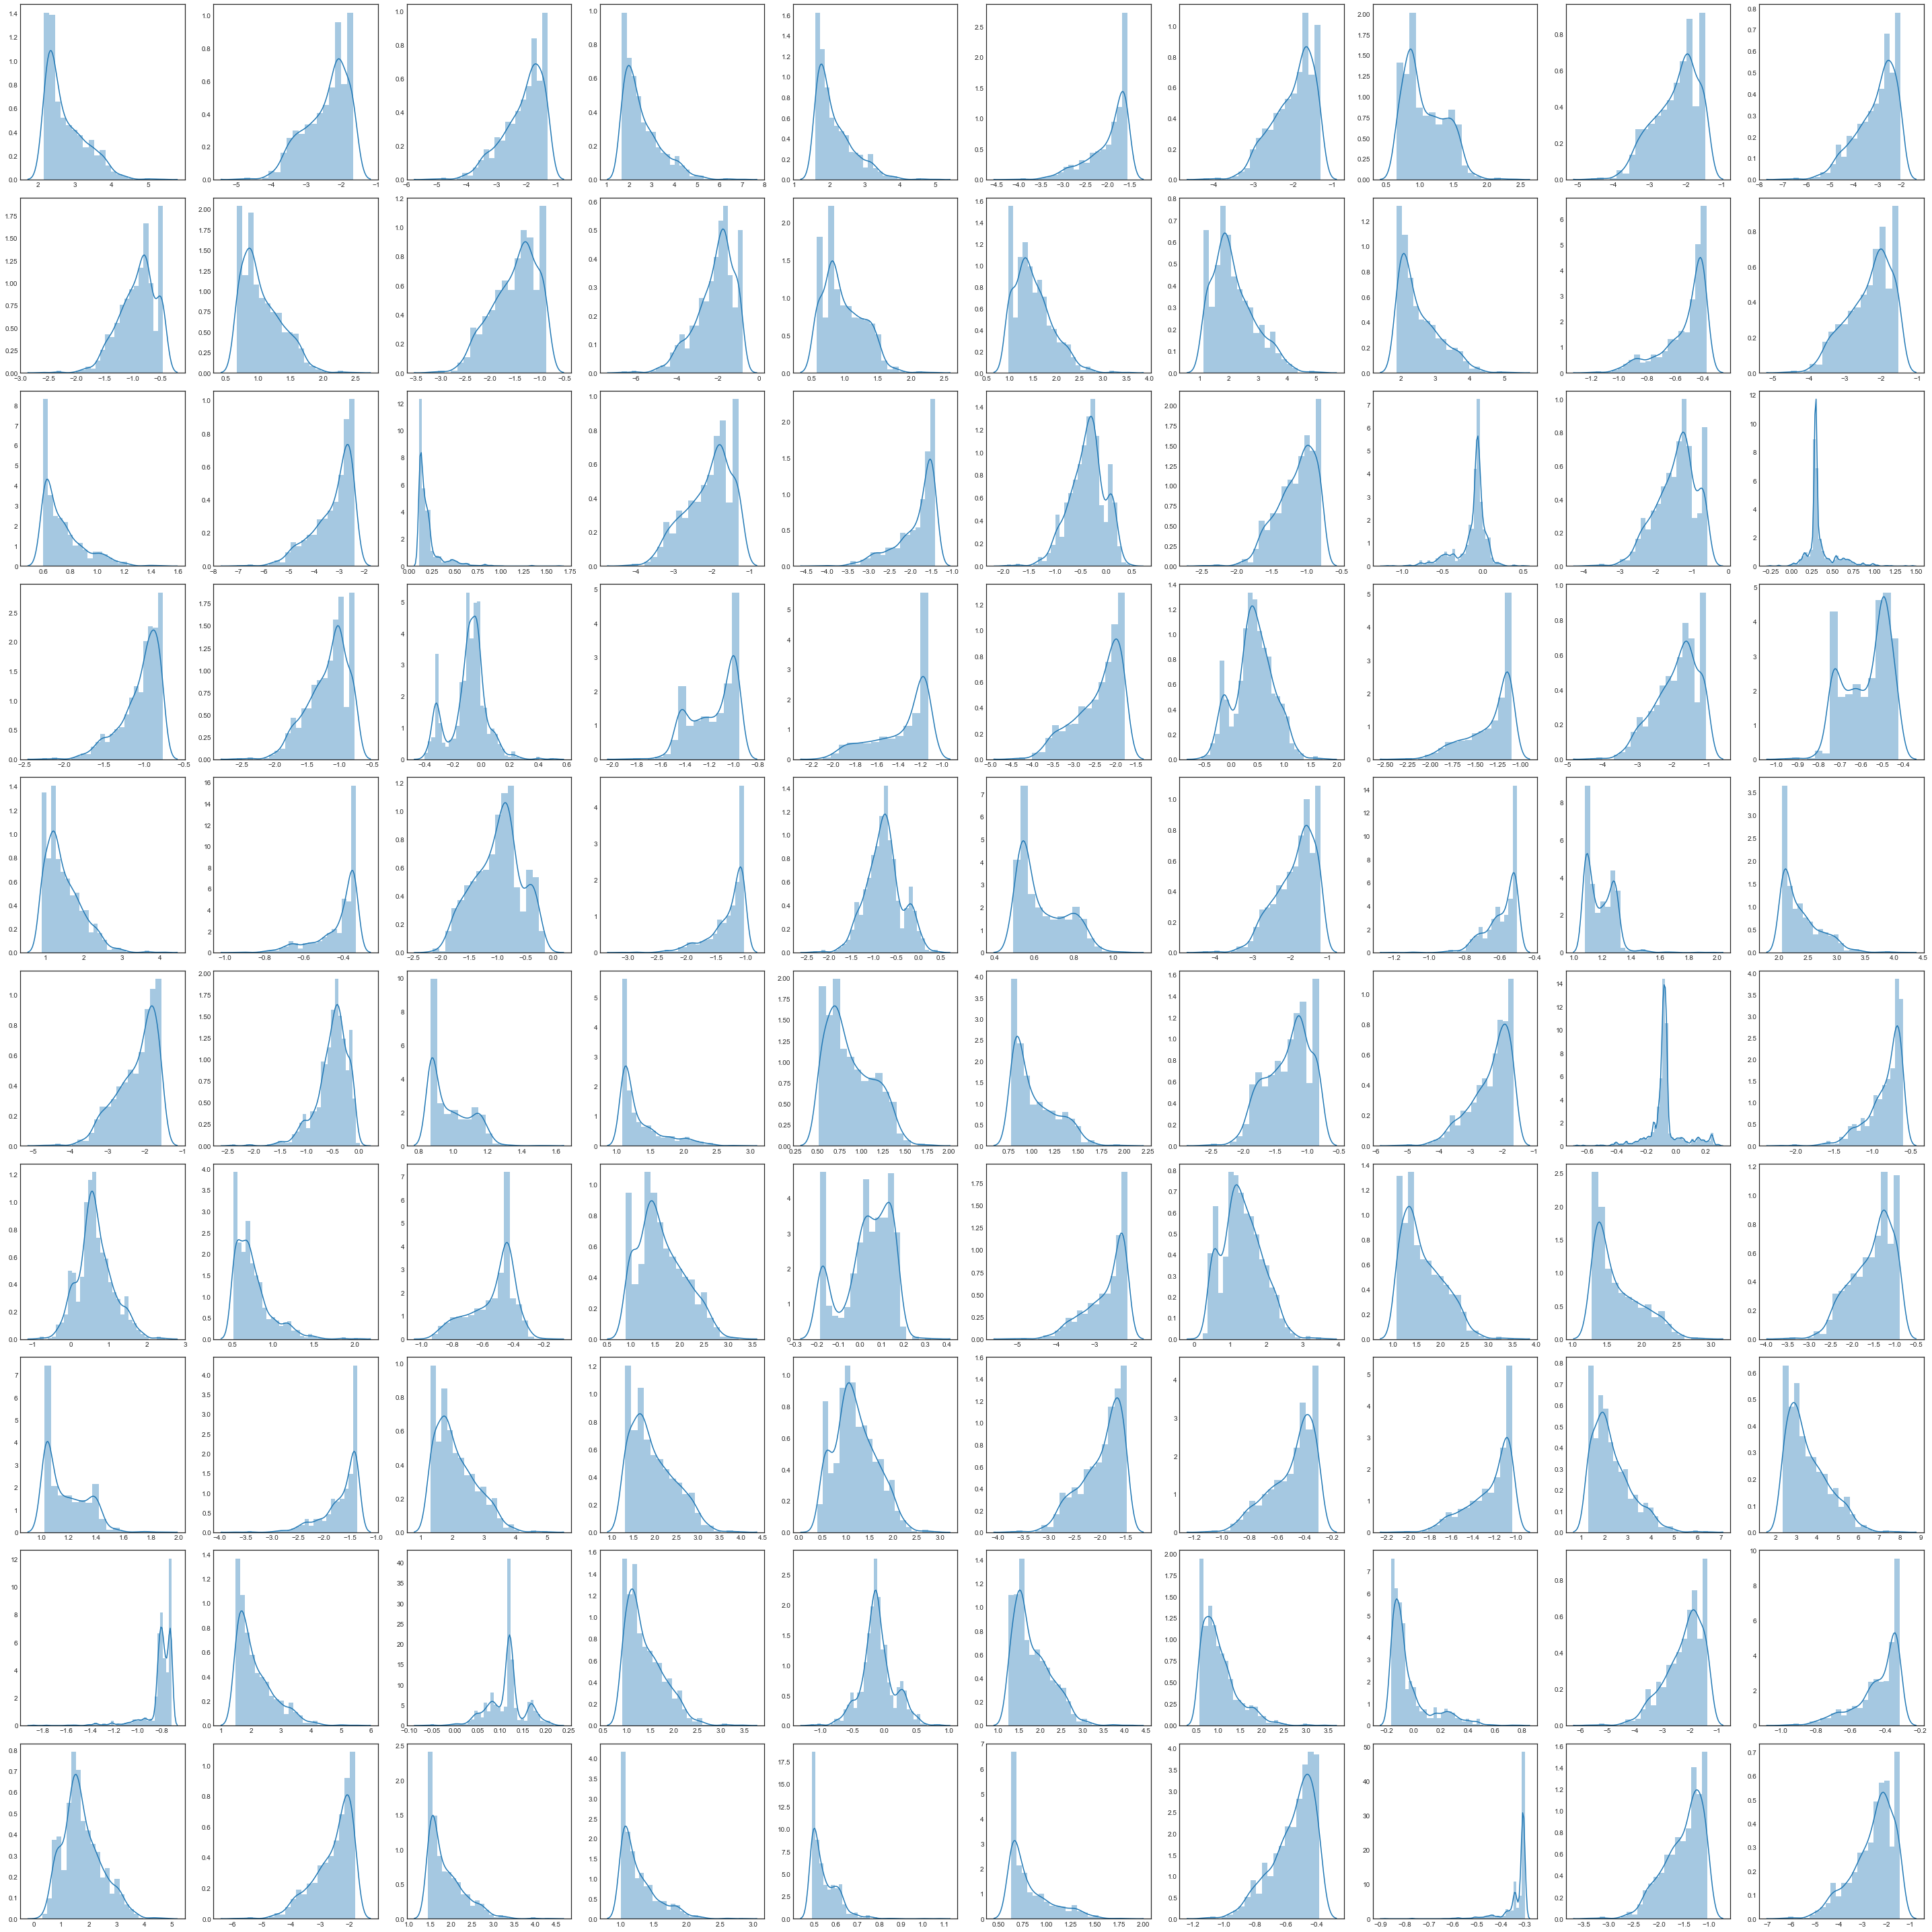

w2


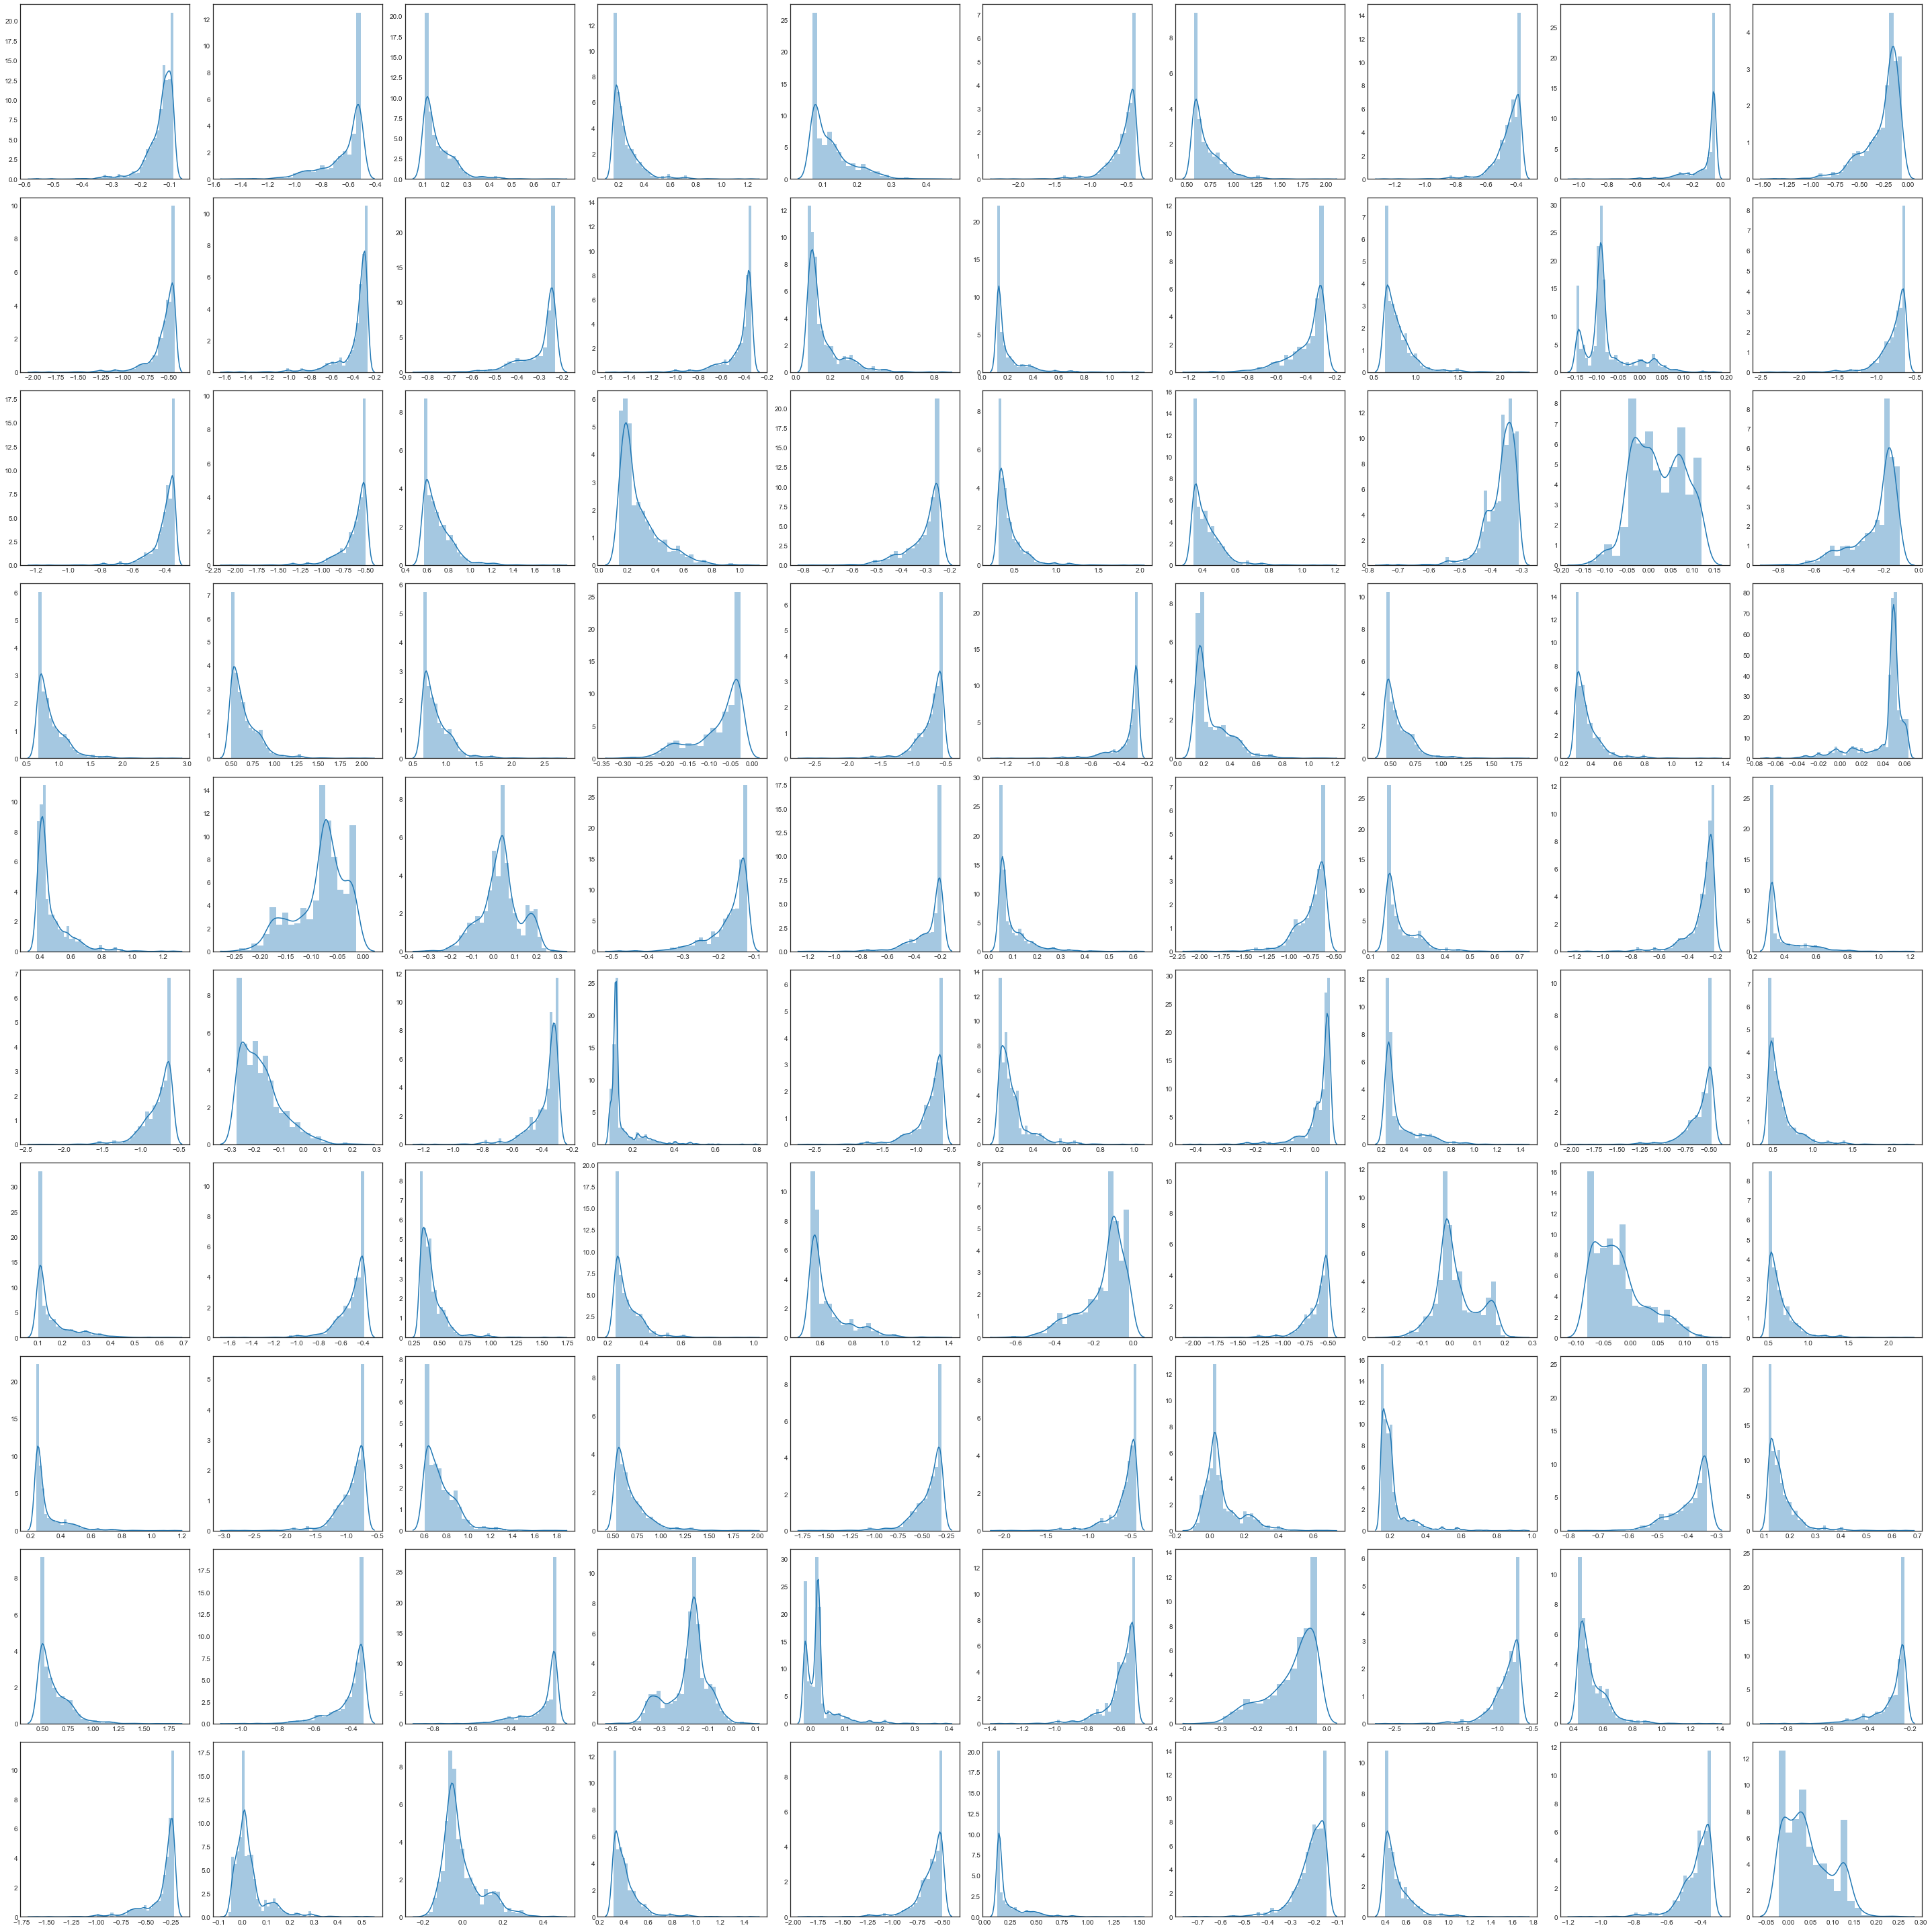

b2


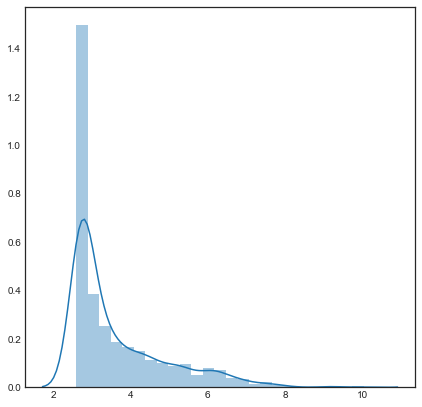

In [14]:
mapping = {0: 'w1', 1: 'b1', 2: 'w2', 3: 'b2'}
for key in weight_dict.keys():
    print(mapping[key])
    weight_dist = np.squeeze(np.array(weight_dict[key]))
    if len(weight_dist.shape) == 1:
        plt.figure(figsize=(7, 7))
        sns.distplot(weight_dist)
        plt.show()
    else:
        fig, axes = plt.subplots(10, 10, figsize=(40, 40), sharey=False)
        for i in range(100):
            row = i // 10
            col = i % 10
            
            sns.distplot(weight_dist[:, i], ax=axes[row, col])
        plt.tight_layout()
        plt.show()

In [15]:
prediction_df.to_csv('toy_example.csv')

try:
    import cPickle as pickle
except:
    import pickle
    
with open('toy_bbh_weight.pickle', 'wb') as f:
    pickle.dump(weight_dict, f)

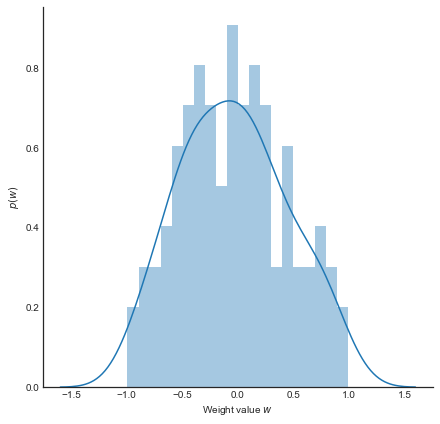

In [16]:
plt.figure(figsize=(7, 7))
sns.distplot(weight_dict[2][-3], bins=20)
sns.despine()
plt.xlabel('Weight value $w$')
plt.ylabel('$p(w)$')
plt.show()